## Figure 2

Comparing sample spaces spanned by perturbations

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "figure2")
extensions <- c(".png", ".pdf")

### Panel A

In [3]:
results_dir <- file.path("../1.Data-exploration/Profiles_level4/results")

In [4]:
# First, obtain the threshold to consider strong phenotype
cell_painting_pr_df <- load_percent_replicating(assay = "cellpainting", results_dir = results_dir)
l1000_pr_df <- load_percent_replicating(assay = "l1000", results_dir = results_dir)

pr_df <- dplyr::bind_rows(cell_painting_pr_df, l1000_pr_df)
pr_df$dose <- factor(pr_df$dose, levels = dose_order)

threshold_df <- pr_df %>%
    dplyr::filter(type == 'non_replicate') %>%
    dplyr::group_by(assay, dose) %>%
    dplyr::summarise(threshold = quantile(replicate_correlation, 0.95))

threshold_plot_ready_df <- threshold_df %>% reshape2::dcast(dose ~ assay, value.var = "threshold")

In [5]:
# Next, get the median scores and determine if they pass the threshold
cell_painting_comp_df <- load_median_correlation_scores(assay = "cellpainting", results_dir = results_dir)
l1000_comp_df <- load_median_correlation_scores(assay = "l1000", results_dir = results_dir)

significant_compounds_df <- cell_painting_comp_df %>%
    dplyr::left_join(l1000_comp_df, by = c("dose", "compound"), suffix = c("_cellpainting", "_l1000")) %>%
    tidyr::drop_na() %>%
    dplyr::left_join(threshold_df %>% dplyr::filter(assay == "Cell Painting"), by = "dose") %>%
    dplyr::left_join(threshold_df %>% dplyr::filter(assay == "L1000"), by = "dose", suffix = c("_cellpainting", "_l1000")) %>%
    dplyr::mutate(
        pass_cellpainting_thresh = median_replicate_score_cellpainting > threshold_cellpainting,
        pass_l1000_thresh = median_replicate_score_l1000 > threshold_l1000
    ) %>%
    dplyr::mutate(pass_both = pass_cellpainting_thresh + pass_l1000_thresh) %>%
    dplyr::mutate(pass_both = ifelse(pass_both == 2, TRUE, FALSE)) %>%
    dplyr::select(compound, dose, median_replicate_score_cellpainting, median_replicate_score_l1000, pass_cellpainting_thresh, pass_l1000_thresh, pass_both)

# Count in how many doses the particular compound was reproducible
cp_reprod_count_df <- significant_compounds_df %>%
    dplyr::filter(pass_cellpainting_thresh) %>%
    dplyr::group_by(compound) %>%
    dplyr::count() %>%
    dplyr::rename(cell_painting_num_reproducible = n)

l1000_reprod_count_df <- significant_compounds_df %>%
    dplyr::filter(pass_l1000_thresh) %>%
    dplyr::group_by(compound) %>%
    dplyr::count() %>%
    dplyr::rename(l1000_num_reproducible = n)

significant_compounds_df <- significant_compounds_df %>%
    dplyr::left_join(cp_reprod_count_df, by = "compound") %>%
    dplyr::left_join(l1000_reprod_count_df, by = "compound") %>%
    tidyr::replace_na(list(l1000_num_reproducible = 0, cell_painting_num_reproducible = 0)) %>%
    dplyr::mutate(total_reproducible = cell_painting_num_reproducible + l1000_num_reproducible)

significant_compounds_df$dose <- factor(significant_compounds_df$dose, levels = dose_order)
significant_compounds_df$compound <- tolower(significant_compounds_df$compound)

# Output file for further use
output_file <- file.path("data", "significant_compounds_by_threshold_both_assays.tsv.gz")
significant_compounds_df %>% readr::write_tsv(output_file)

print(dim(significant_compounds_df))
head(significant_compounds_df, 3)

Warning message:
“Column `dose` joining character vector and factor, coercing into character vector”
Warning message:
“Column `dose` joining character vector and factor, coercing into character vector”


[1] 7962   10


compound,dose,median_replicate_score_cellpainting,median_replicate_score_l1000,pass_cellpainting_thresh,pass_l1000_thresh,pass_both,cell_painting_num_reproducible,l1000_num_reproducible,total_reproducible
<chr>,<fct>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
17-hydroxyprogesterone-caproate,0.04 uM,0.06065485,0.02473778,TRUE,FALSE,FALSE,5,3,8
2-iminobiotin,0.04 uM,0.04270010,-0.13369283,FALSE,FALSE,FALSE,0,2,2
3-amino-benzamide,0.04 uM,0.10427276,0.05195868,TRUE,FALSE,FALSE,5,1,6


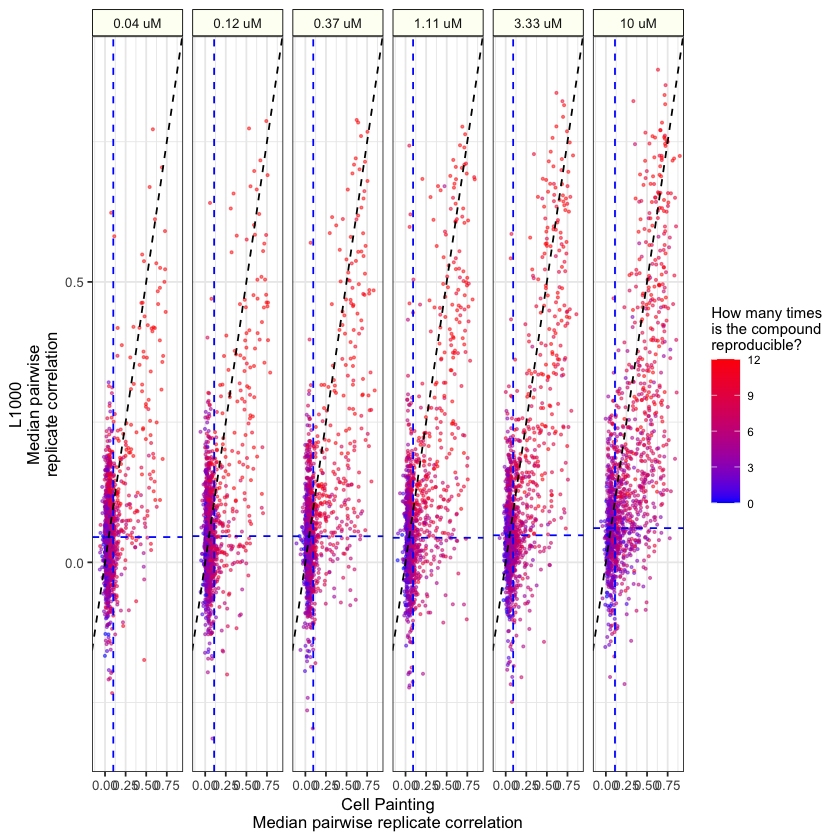

In [6]:
panel_a_gg <- (
    ggplot(significant_compounds_df, aes(x = median_replicate_score_cellpainting, y = median_replicate_score_l1000))
    + geom_point(aes(color = total_reproducible), size = 0.5, alpha = 0.5)
    + facet_grid("~dose")
    + geom_hline(data = threshold_plot_ready_df, aes(yintercept = `Cell Painting`), linetype = "dashed", color = "blue")
    + geom_vline(data = threshold_plot_ready_df, aes(xintercept = L1000), linetype = "dashed", color = "blue")
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black")
    + figure_theme
    + scale_color_gradient("How many times\nis the compound\nreproducible?", low = "blue", high = "red")
    + xlab("Cell Painting\nMedian pairwise replicate correlation")
    + ylab("L1000\nMedian pairwise\nreplicate correlation")
)

panel_a_gg

### Panel B

In [7]:
results_dir <- file.path("../1.Data-exploration/Consensus/")

pm_cellpainting_list <- load_percent_matching(assay = "cellpainting", results_dir = results_dir)
pm_l1000_list <- load_percent_matching(assay = "l1000", results_dir = results_dir)

p_val_alpha_thresh <- 0.05
no_replicates_thresh <- 3

cell_painting_pm_df <- pm_cellpainting_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_df <- pm_l1000_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_df <- dplyr::bind_rows(cell_painting_pm_df, l1000_pm_df)

cell_painting_pm_pval_df <- pm_cellpainting_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_pval_df <- pm_l1000_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_pval_df <- dplyr::bind_rows(cell_painting_pm_pval_df, l1000_pm_pval_df)

pm_df <- pm_df %>%
    dplyr::left_join(pm_pval_df, by = c("moa", "dose", "assay", "no_of_replicates")) %>%
    dplyr::mutate(pass_thresh = p_value < p_val_alpha_thresh) %>%
    dplyr::mutate(neg_log_10_p_val = -log10(p_value))

pm_df$dose <- factor(pm_df$dose, levels = dose_order)

pm_df$neg_log_10_p_val[pm_df$neg_log_10_p_val == Inf] = 3.5

print(dim(pm_df))
head(pm_df)

[1] 1524    8


moa,no_of_replicates,dose,matching_score,assay,p_value,pass_thresh,neg_log_10_p_val
<chr>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<lgl>,<dbl>
acat inhibitor,3,0.04 uM,-0.307784325,Cell Painting,0.864,FALSE,0.06348626
acetylcholine receptor agonist,8,0.04 uM,0.180001558,Cell Painting,0.084,FALSE,1.07572071
acetylcholine receptor antagonist,21,0.04 uM,0.032421545,Cell Painting,0.362,FALSE,0.44129143
adenosine receptor agonist,3,0.04 uM,-0.285657222,Cell Painting,0.839,FALSE,0.07623804
adenosine receptor antagonist,4,0.04 uM,0.180486665,Cell Painting,0.159,FALSE,0.79860288
adrenergic receptor agonist,20,0.04 uM,0.009038156,Cell Painting,0.610,FALSE,0.21467016


In [8]:
# Prep additional data for plotting
replicate_counts_df <- pm_df %>%
    tidyr::drop_na() %>%
    dplyr::group_by(moa, dose) %>%
    dplyr::mutate(avg_replicate_count = mean(no_of_replicates)) %>%
    dplyr::select(moa, dose, avg_replicate_count) %>%
    dplyr::ungroup() %>%
    dplyr::distinct()

cp_pass_thresh <- pm_df %>%
    dplyr::filter(assay == "Cell Painting", pass_thresh) %>%
    dplyr::select(moa, dose, pass_thresh) %>%
    dplyr::rename(pass_thresh_cellpainting = pass_thresh)

l1000_pass_thresh <- pm_df %>%
    dplyr::filter(assay == "L1000", pass_thresh) %>%
    dplyr::select(moa, dose, pass_thresh) %>%
    dplyr::rename(pass_thresh_l1000 = pass_thresh)

pass_thresh_both <- cp_pass_thresh %>%
    dplyr::full_join(l1000_pass_thresh, by = c("moa", "dose")) %>%
    tidyr::replace_na(list(pass_thresh_cellpainting = FALSE, pass_thresh_l1000 = FALSE)) %>%
    dplyr::mutate(pass_both = pass_thresh_cellpainting + pass_thresh_l1000) %>%
    dplyr::mutate(pass_both = ifelse(pass_both == 2, TRUE, FALSE)) %>%
    dplyr::mutate(moa_color_passing = 0)

pass_thresh_both$moa_color_passing[pass_thresh_both$pass_both] <- "#DF74F0"
pass_thresh_both$moa_color_passing[(pass_thresh_both$pass_thresh_cellpainting & !pass_thresh_both$pass_both)] <- paste(assay_colors["Cell Painting"])
pass_thresh_both$moa_color_passing[(pass_thresh_both$pass_thresh_l1000 & !pass_thresh_both$pass_both)] <- assay_colors["L1000"]

head(pass_thresh_both)

moa,dose,pass_thresh_cellpainting,pass_thresh_l1000,pass_both,moa_color_passing
<chr>,<fct>,<lgl>,<lgl>,<lgl>,<chr>
aromatase inhibitor,0.04 uM,TRUE,FALSE,FALSE,#F0C178
benzodiazepine receptor agonist,0.04 uM,TRUE,FALSE,FALSE,#F0C178
cdk inhibitor,0.04 uM,TRUE,FALSE,FALSE,#F0C178
cholesterol inhibitor,0.04 uM,TRUE,FALSE,FALSE,#F0C178
dipeptidyl peptidase inhibitor,0.04 uM,TRUE,FALSE,FALSE,#F0C178
gaba receptor modulator,0.04 uM,TRUE,FALSE,FALSE,#F0C178


In [9]:
plot_ready_pm_df <- pm_df %>%
    reshape2::dcast(moa + dose ~ assay, value.var = "matching_score") %>%
    tidyr::drop_na() %>%
    dplyr::left_join(replicate_counts_df, by = c("moa", "dose")) %>%
    dplyr::left_join(pass_thresh_both, by = c("moa", "dose")) %>%
    tidyr::replace_na(
        list(
            pass_thresh_cellpainting = FALSE,
            pass_thresh_l1000 = FALSE,
            pass_both = FALSE,
            moa_color_passing = "lightgrey"
        )
    )

# Output file for further use
output_pm_file <- file.path("data", "significant_moas_by_threshold_both_assays.tsv.gz")
plot_ready_pm_df %>% readr::write_tsv(output_pm_file)

head(plot_ready_pm_df)

,moa,dose,Cell Painting,L1000,avg_replicate_count,pass_thresh_cellpainting,pass_thresh_l1000,pass_both,moa_color_passing
,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>
1,acat inhibitor,0.04 uM,-0.30778432,-0.068682491,3,FALSE,FALSE,FALSE,lightgrey
2,acat inhibitor,0.12 uM,-0.06288375,-0.124012771,3,FALSE,FALSE,FALSE,lightgrey
3,acat inhibitor,0.37 uM,-0.14347574,0.004646673,3,FALSE,FALSE,FALSE,lightgrey
4,acat inhibitor,1.11 uM,-0.44344260,-0.027784508,3,FALSE,FALSE,FALSE,lightgrey
5,acat inhibitor,3.33 uM,-0.37843292,-0.072057893,3,FALSE,FALSE,FALSE,lightgrey
6,acat inhibitor,10 uM,0.16255862,-0.053541706,3,FALSE,FALSE,FALSE,lightgrey


In [10]:
passing_colors <- unique(plot_ready_pm_df$moa_color_passing)
names(passing_colors) <- unique(plot_ready_pm_df$moa_color_passing)

passing_labels <- c("None", "L1000 Only", "CP Only", "Both")
names(passing_labels) <- unique(plot_ready_pm_df$moa_color_passing)

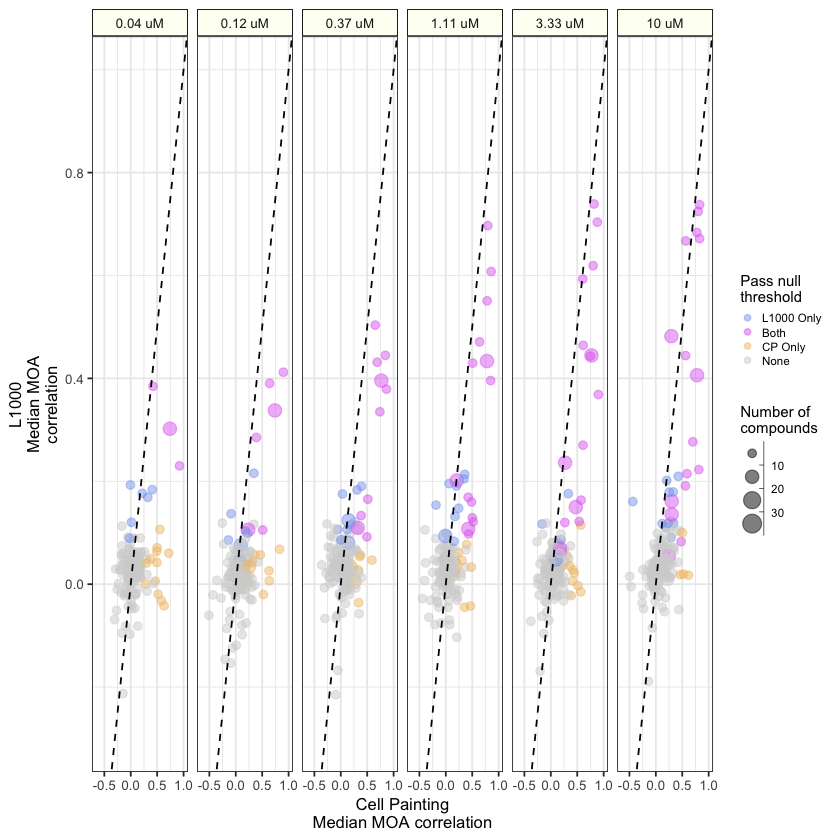

In [11]:
panel_b_gg <- (
    ggplot(plot_ready_pm_df, aes(x = `Cell Painting`, y = L1000))
    + geom_point(aes(size = avg_replicate_count, color = moa_color_passing), alpha = 0.5)
    + facet_grid("~dose")
    + figure_theme
    + scale_color_manual(
        "Pass null\nthreshold",
        values = passing_colors,
        labels = passing_labels
    )
    + scale_size_binned("Number of\ncompounds", range = c(0.5, 5))
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black")
    + xlim(c(-0.65, 1))
    + ylim(c(-0.3, 1))
    + xlab("Cell Painting\nMedian MOA correlation")
    + ylab("L1000\nMedian MOA\ncorrelation")
    + theme(legend.key.size = unit(0.3, 'cm'))
)

panel_b_gg

### Panel C

In [12]:
moa_count_filter <- 2

moa_match_df <- pm_df %>% dplyr::filter(pass_thresh)

consistent_match_moa_df <- moa_match_df %>%
    dplyr::group_by(assay, moa) %>%
    dplyr::tally() %>%
    dplyr::filter(n >= !!moa_count_filter) %>%
    reshape2::dcast(moa ~ assay, value.var = "n") %>%
    tidyr::replace_na(
        list(
            `Cell Painting` = 0,
            L1000 = 0
        )
    ) %>%
    dplyr::mutate(x_axis_location = "Cell Painting")

consistent_match_moa_df$x_axis_location[consistent_match_moa_df$L1000 > 0] = "L1000"
consistent_match_moa_df$x_axis_location[(consistent_match_moa_df$L1000 > 0 & consistent_match_moa_df$`Cell Painting` > 0)] = "Both"

# Define the order to plot the text
cell_painting_order <- consistent_match_moa_df %>%
    dplyr::filter(x_axis_location == "Cell Painting") %>%
    dplyr::arrange(`Cell Painting`, moa) %>%
    dplyr::mutate(y_axis_location = seq(1, n() * 3, 3)) %>%
    dplyr::select(moa, y_axis_location)

l1000_order <- consistent_match_moa_df %>%
    dplyr::filter(x_axis_location == "L1000") %>%
    dplyr::arrange(L1000, moa) %>%
    dplyr::mutate(y_axis_location = seq(1, n() * 3, 3)) %>%
    dplyr::select(moa, y_axis_location)

both_order <- consistent_match_moa_df %>%
    dplyr::mutate(both_count = (`Cell Painting` + L1000) / 2) %>%
    dplyr::filter(x_axis_location == "Both") %>%
    dplyr::arrange(both_count, moa) %>%
    dplyr::mutate(y_axis_location = seq(1, n() * 3, 3)) %>%
    dplyr::select(moa, y_axis_location)

full_moa_plot_order <- dplyr::bind_rows(cell_painting_order, l1000_order, both_order)

plot_ready_moa_text_df <- consistent_match_moa_df %>% dplyr::left_join(full_moa_plot_order, by = "moa") %>%
    dplyr::mutate(replicate_count = `Cell Painting` + L1000)

plot_ready_moa_text_df$x_axis_location <- factor(plot_ready_moa_text_df$x_axis_location, levels = c("Cell Painting", "Both", "L1000"))

head(plot_ready_moa_text_df)

,moa,Cell Painting,L1000,x_axis_location,y_axis_location,replicate_count
,<chr>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
1,acetylcholine receptor agonist,0,2,L1000,1,2
2,acetylcholine receptor antagonist,2,0,Cell Painting,1,2
3,adenosine receptor antagonist,0,2,L1000,4,2
4,adrenergic receptor antagonist,2,0,Cell Painting,4,2
5,akt inhibitor,3,0,Cell Painting,40,3
6,androgen receptor agonist,2,4,Both,10,6


In [13]:
moa_labels <- c("None", "L1000", "Cell Painting", "Both")

moa_colors <- unique(plot_ready_pm_df$moa_color_passing)
names(moa_colors) <- moa_labels
names(moa_labels) <- moa_labels

In [14]:
panel_c_gg <- (
    ggplot(plot_ready_moa_text_df, aes(y = y_axis_location, x = 0))
    + geom_text(aes(label = moa, color = x_axis_location, size = replicate_count))
    + facet_wrap("~x_axis_location", strip.position = "bottom")
    + theme_void()
    + theme(strip.text = element_text(size = 14))
    + scale_color_manual(
        "Pass null\nthreshold",
        values = moa_colors,
        labels = moa_labels,
        guide = "none"
    )
    + scale_size(
        "Number of\npassing doses",
        range = c(4, 7),
        guide = "none"
    )
    + xlim(-100, 100)
    + ylim(0, 47)
)

### Compile figure together

Warning message:
“Removed 1 rows containing missing values (geom_text).”


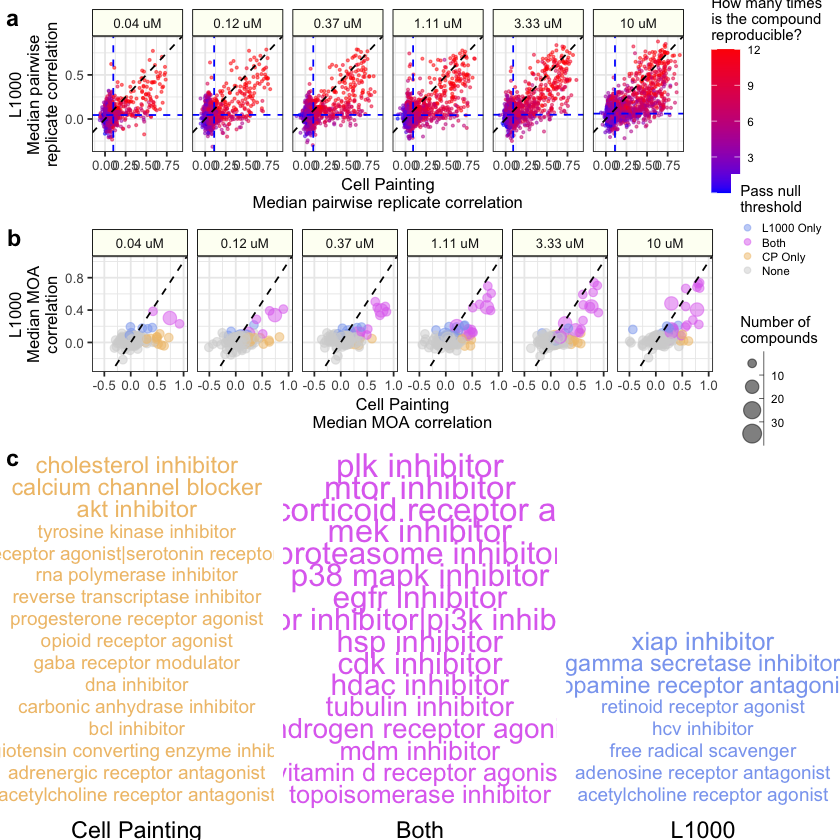

In [15]:
figure_2_gg <- cowplot::plot_grid(
    panel_a_gg,
    panel_b_gg,
    panel_c_gg,
    nrow = 3,
    labels = c("a", "b", "c"),
    rel_heights = c(0.55, 0.55, 1)
)

figure_2_gg

In [16]:
for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    cowplot::save_plot(output_file, figure_2_gg, base_width = 12, base_height = 10, dpi = 500)
}